Atividade 06 da disciplina de Visão Robótica

Discente: Henrique Antônio Guanais Corneau

# Homografia e RANSAC

Dadas duas imagens de um objeto planar (por exemplo, a capa de um
livro):
1. Extraia pontos e descritores SIFT nas duas imagens

Para realizar isso, está sendo utilizado o algoritmo SIFT, em que na função `get_SIFT_descriptors()` é criado o objeto sift, e depois calculado os keypoints e descritores de uma imagem.

In [309]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


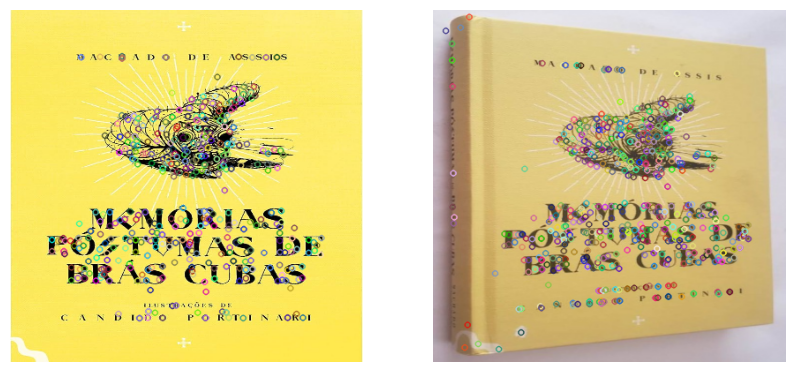

In [310]:
# extrair pontos e descritores SIFT
img1 = cv2.imread("../imagens/livro1.jpg")
img2 = cv2.imread("../imagens/livro2.jpg")
# redimensiona para que as imagens tenham o mesmo tamanho
img1 = cv2.resize(img1, (400, 400))
img2 = cv2.resize(img2, (400, 400))

img_gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img_gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


def get_SIFT_descriptors(img):
    """Função que recebe uma imagem e retorna os pontos e descritores SIFT"""
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des


kp1, des1 = get_SIFT_descriptors(img_gray1)
kp2, des2 = get_SIFT_descriptors(img_gray2)
# desenha os keypoints nas imagens
img1_keypoints = cv2.drawKeypoints(img1, kp1, None)
img2_keypoints = cv2.drawKeypoints(img2, kp2, None)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1_keypoints, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2_keypoints, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

2. Realize o casamento (matching) entre os descritores de ambas as
imagens

Para isso foi utilizado as funções do opencv: `cv2.FlannBasedMatcher()` e `flann.knnMatch()`, que realiza matching entre os descritores utilizando o algoritmo K-D Tree.

Em: 
```
good_matches = []
for m, n in matches:
    if m.distance < 0.78 * n.distance:
        good_matches.append(m)
```
Foi realizado uma filtragem para alguns valores extremos de matches.

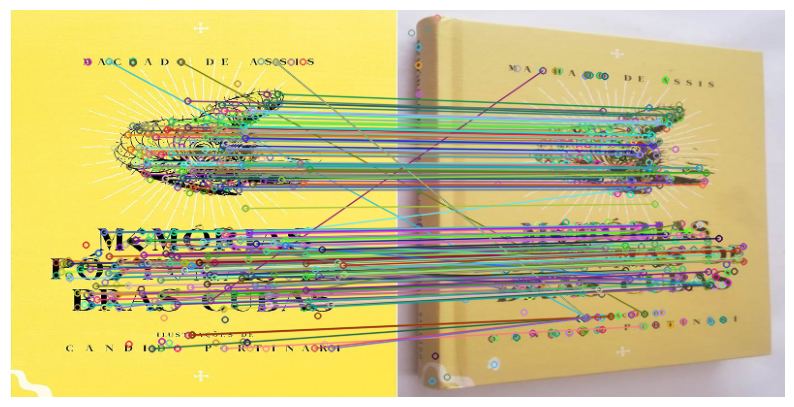

In [ ]:
# cacula os matches entre os descritores a partir do algoritmo K-D Tree
index_params = dict(algorithm = 1, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

# filtra alguns valores de matches
good_matches = []
for m, n in matches:
    if m.distance < 0.78 * n.distance:
        good_matches.append(m)

# desenha os matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

3. Utilize RANSAC para estimar uma homografia entre o plano
presente na imagem 1 e o mesmo plano presente na imagem 2.
Exiba os casamentos dos pontos com a cor verde para os inliers
(casamentos “corretos”) e a cor vermelha para os outliers
(casamentos “incorretos”).

Primeiramente, foi feito a função `homografia()`, que recebe os matches e retorna a matriz de homografia. `src_pts` são os pontos da imagem 1, e `dst_pts` são os pontos que foram feitas as correspondências na imagem 2.

Posteriormente no laço de repetição, foi feita a matriz A, que leva em consideração os pontos `(x1, y1)` de origem e `(x2, y2)` de destino para ficar semelhante à esse formato:
$$
\begin{bmatrix}
-x_1 & -y_1 & -1 & 0 & 0 & 0 & x_1x_1' & y_1x_1' & x_1' \\
0 & 0 & 0 & -x_1 & -y_1 & -1 & x_1y_1' & y_1y_1' & y_1' \\
-x_2 & -y_2 & -1 & 0 & 0 & 0 & x_2x_2' & y_2x_2' & x_2' \\
0 & 0 & 0 & -x_2 & -y_2 & -1 & x_2y_2' & y_2y_2' & y_2' \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
-x_n & -y_n & -1 & 0 & 0 & 0 & x_nx_n' & y_nx_n' & x_n' \\
0 & 0 & 0 & -x_n & -y_n & -1 & x_ny_n' & y_ny_n' & y_n'
\end{bmatrix}
$$

Essa matriz A é importante para determinar a matriz de homografia `h`, uma vez que:
$$
A \cdot h = 0
$$

Portanto, para determinar a matriz h, foi utilizado SVD ` _, _, v = np.linalg.svd(A)`.
E então, a matriz h foi redimensionada e normalizada para futuros cálculos.



In [312]:
def homografia(matches):
    """Função que recebe os matches e retorna a matriz de homografia"""	
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

    A = np.zeros((2*len(matches), 9))
    for i in range(len(matches)):
        x1, y1 = src_pts[i][0]
        x2, y2 = dst_pts[i][0]
        A[2*i] = np.array([-x1, -y1, -1, 0, 0, 0, x1*x2, y1*x2, x2])
        A[2*i+1] = np.array([0, 0, 0, -x1, -y1, -1, x1*y2, y1*y2, y2])
    # resolve o sistema A*h = 0 por SVD
    _, _, v = np.linalg.svd(A)
    # redimensiona a matriz de homografia para 3x3
    h = np.reshape(v[8], (3, 3))
    # normaliza a matriz de homografia para que h[2,2] = 1
    h /= h.item(8)
    return h, src_pts, dst_pts

O algoritmo de ransac vai iterar `N` vezes, em que o primeiro passo é selecionar 4 pontos aleátorios e calcular a nova matriz de homografia.
```
for i in range(N):
        new_matches = np.random.choice(matches, s, replace=False)
        h, _, _ = homografia(new_matches)
```
Com essa nova matriz de homografia, o próximo passo é percorrer todos os matches, calculando a distância euclidiana entre os pontos preditos e os pontos reais:
```
for i in range(n_points):
            p1 = np.append(src_pts[i][0], 1)
            p2 = np.append(dst_pts[i][0], 1)
            # calcula as coordenadas cartesianas dos pontos preditos
            p2_pred = h @ p1
            p1_pred = np.linalg.inv(h) @ p2
            p2_pred = p2_pred / p2_pred[2]  
            p1_pred = p1_pred / p1_pred[2]
            # calcula a distancia euclidiana entre os pontos preditos e os reais
            distancia_homografia = distancia_euclidiana(p2_pred, p2)**2 + distancia_euclidiana(p1_pred, p1)**2
```
Caso esse valor de distância seja menor que um valor `t`, então o valor está apto a ser um inlier, caso contrário será considerado um outlier.

O algoritmo para caso o tamanho do vetor `inliers` seja maior que `T` tamanho máximo para o conjunto consenso, ou se o número `N` de iterações for atingido.

Por fim, os inliers foram exibidos por retas verdes, enquanto que os outliers, por retas vermelhas.


Matches: 228
Inliers: 120
Outliers: 108


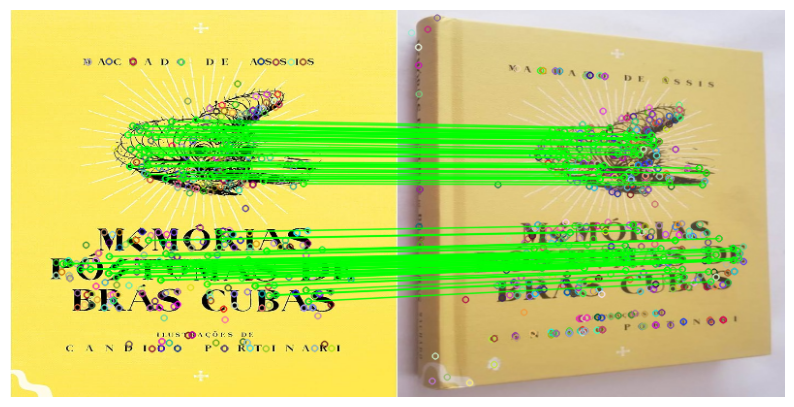

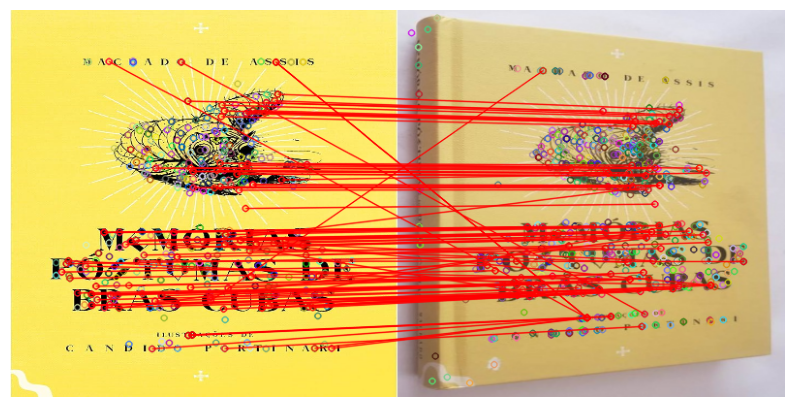

In [ ]:
def distancia_euclidiana(p1, p2):
    """Função que calcula a distância euclidiana entre dois pontos"""
    return np.sqrt(np.sum((p1 - p2)**2))

def ransac(matches, t=3, p=0.99, s=4):
    """Função que realiza o algoritmo de ransac, recebe os matches e retorna os inliers e outliers"""
    e = 0.5
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    n_points = len(matches)
    N = int(np.ceil(np.log(1-p)/np.log(1-(1-e)**s)))
    T = int(np.ceil((1-e)*n_points))
    inliers = []
    outliers = []
    
    for i in range(N):
        new_matches = np.random.choice(matches, s, replace=False)
        h, _, _ = homografia(new_matches)
        
        for i in range(n_points):
            p1 = np.append(src_pts[i][0], 1)
            p2 = np.append(dst_pts[i][0], 1)
            # calcula as coordenadas cartesianas dos pontos preditos
            p2_pred = h @ p1
            p1_pred = np.linalg.inv(h) @ p2
            p2_pred = p2_pred / p2_pred[2]  
            p1_pred = p1_pred / p1_pred[2]
            # calcula a distancia euclidiana entre os pontos preditos e os reais
            distancia_homografia = distancia_euclidiana(p2_pred, p2)**2 + distancia_euclidiana(p1_pred, p1)**2
            if distancia_homografia < t:
                if matches[i] not in inliers:
                    inliers.append(matches[i])
            
        if len(inliers) > T:
            break
        
    outliers = [match for match in matches if match not in inliers]
    
    return inliers, outliers

inliers, outliers = ransac(good_matches)
print(f"Matches: {len(good_matches)}")
print(f"Inliers: {len(inliers)}")
print(f"Outliers: {len(outliers)}")

inliers_matches = cv2.drawMatches(img1, kp1, img2, kp2, inliers, None, matchColor=(0, 255, 0))
outliers_matches = cv2.drawMatches(img1, kp1, img2, kp2, outliers, None, matchColor=(0, 0, 255))

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(inliers_matches, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(outliers_matches, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()